In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import math
import matplotlib.pyplot as plt

from mplsoccer import Pitch, VerticalPitch
from matplotlib.colors import to_rgba
from mplsoccer.statsbomb import read_event, EVENT_SLUG
from matplotlib import cm
from matplotlib import colorbar
from matplotlib.colors import LinearSegmentedColormap
from highlight_text import fig_text


In [15]:
df = pd.read_csv(r'C:\Users\Feele\Documents\Data\Sunderland\locationfilter.csv')


# PLAYER ID 

In [16]:
#Make a new, single column for time and sort the events in chronological order

df.sort_values(by=['minute'])

#identify the passer and then the recipient, who'll be the playerId of the next action
df['passer'] = df['number'] # change to 'player_num' for nodes with numbers. Use 'playerId' if not.

df['recipient'] = df['passer'].shift(-1)

#filter for only passes and then successful passes
Passes = df.loc[(df['type/displayName']=="Pass")]


Completions = Passes.loc[(Passes['outcomeType/displayName']=="Successful")]

pas = pd.to_numeric(Completions['passer'],downcast='integer')
rec = pd.to_numeric(Completions['recipient'],downcast='integer')

Completions['passer'] = pas
Completions['recipient'] = rec

<ipython-input-16-04dc96234dfd>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Completions['passer'] = pas
<ipython-input-16-04dc96234dfd>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Completions['recipient'] = rec


In [17]:
#find time of the team's first substitution and filter the df to only passes before that
Subs = df.loc[(df['type/displayName']=="SubstitutionOff")]
SubTimes = Subs["minute"]
SubOne = SubTimes.min()


SubTimes
#SubOne

Series([], Name: minute, dtype: int64)

In [5]:
Completions = Completions.loc[Completions['minute'] < SubOne]

In [18]:
#Find Average Locations 
average_locs_and_count = Completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean','count']})
average_locs_and_count.columns = ['x', 'y', 'count']

In [19]:
average_locs_and_count

,x,y,count
passer,,,
2,53.518750,11.312500,16
5,40.000000,41.516667,6
6,56.207143,88.721429,14
7,65.964706,42.323529,17
8,61.181818,64.290909,11
9,59.580000,47.190000,10
13,12.966667,52.283333,6
14,62.033333,72.950000,6
22,55.481250,54.825000,16


In [20]:
#find number of passes along each 'path' of passer to recipient
passes_between = Completions.groupby(['passer', 'recipient']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='recipient', right_index=True,
                                      suffixes=['', '_end'])

In [21]:
size=1000
radius = math.sqrt(size)/2.
arrow = mpl.patches.FancyArrowPatch(posA=(1.2*passes_between.x,80-.8*passes_between.y), 
                                    posB=(1.2*passes_between.x_end,80-.8*passes_between.y_end),                                    
                                    arrowstyle='->', mutation_scale=70, shrinkA=radius, shrinkB=radius)

#### Light Pitch 

Background - #FFFFFF
lines - #B4B6BA

#### Dark Pitch

Background - #1B1B1B
lines - #c7d5cc

#### Blue Pitch (Primary colour)
Background - #0B0725
lines - #B4B6BA

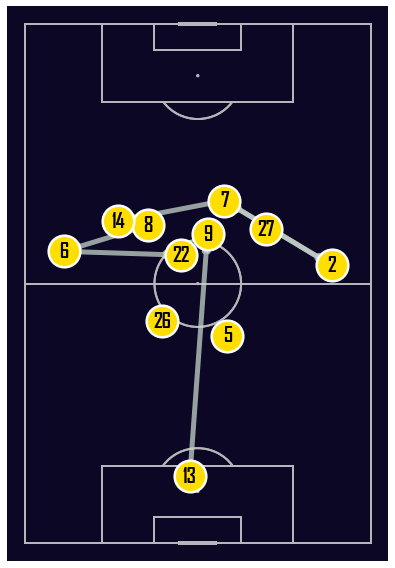

In [22]:
#set minimum threshold for pass arrows to be plotted. So this will only plot combos which occured at least 5 times.
passes_between = passes_between.loc[(passes_between['pass_count']>3)]

pitch = VerticalPitch(pitch_color='#0B0725', line_color='#B4B6BA', figsize=(13, 8),
              constrained_layout=True, tight_layout=False,half=False)
fig, ax = pitch.draw(figsize=(13,8))

pitch.draw(ax=ax)


def pass_line_template(ax, x, y, end_x, end_y, line_color):
    ax.annotate('', xy=(80-.8*end_y, 1.2*end_x), xytext=(80-.8*y, 1.2*x), zorder=1,
    arrowprops=dict(arrowstyle='->', linewidth=5, color='#c7d5cc', alpha=.75))
    
def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, dist_delta=1.2):
    dist = math.hypot(end_x - x, end_y - y)
    angle = math.atan2(end_y-y, end_x-x)
    upd_x = x + (dist - dist_delta) * math.cos(angle)
    upd_y = y + (dist - dist_delta) * math.sin(angle)
    pass_line_template(ax, x, y, upd_x, upd_y, line_color=line_color)


#Plotting Circles

pass_nodes = pitch.scatter(1.2*average_locs_and_count.x, 80-0.8*average_locs_and_count.y, s=1000,
                           color='#ffde00', edgecolors="#ffffff", linewidth=2.5, alpha=1, ax=ax, zorder=1.5)
    
#Plotting Lines

for index, row in passes_between.iterrows():
    pass_line_template_shrink(ax,row['x'],row['y'],row['x_end'],row['y_end'],line_color = 'white')
                    
# Plotting Numbers
for index, row in average_locs_and_count.iterrows():
     pitch.annotate(row.name, xy=(1.2*row.x, 80-0.8*row.y), c='black', va='center', ha='center', size=20, fontweight='bold', fontfamily="Agency FB",ax=ax)


plt.savefig('test.png',dpi=500,bbox_inches = 'tight')        

https://htmlcolorcodes.com/color-picker/ to change colours.